In [1]:
#pip install pmdarima
#!pip install prophet

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.ar_model import AutoReg
from pmdarima import auto_arima
from scipy.stats import shapiro
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_white
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from prophet import Prophet

## Для начала считываю данные и делаю дату индексом

In [3]:
data = pd.read_excel('data_test.xlsx' , sheet_name = 1)

In [4]:
data

,date,kpi,price,queries,repr_cost,repr_count,banner_quant,banner_cost,context_quant,context_cost,...,tv_creative_1,tv_creative_2,tv_creative_3,tv_cost,tvr_competitor_1,tvr_competitor_2,tvr_competitor_3,tvr_competitor_4,tvr_competitor_5,tvr_competitor_6
0,2018-12-31,95353,143,645354,1508543,2193,0,0,9221,44533,...,0,0,0,0,205,397,253,121,249,331
1,2019-01-07,124278,143,615454,1508543,2193,0,0,9221,44533,...,281,0,0,12490514,270,433,202,204,248,319
2,2019-01-14,125637,143,573170,2724790,3960,0,0,9221,44533,...,222,0,0,9835858,228,235,136,206,270,284
3,2019-01-21,149294,143,661720,2646358,3846,0,0,9221,44533,...,198,0,0,8800458,277,335,75,168,340,305
4,2019-01-28,178678,143,764809,2456814,3571,0,0,9221,44533,...,242,0,0,10754487,0,207,0,353,57,212
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,2022-02-28,182791,183,642621,2898815,4053,7178,623279,8450,88478,...,0,256,0,10461422,0,206,151,169,0,204
166,2022-03-07,163479,183,583139,1605684,2245,7326,647609,14166,158176,...,0,316,0,12902261,0,37,184,189,0,243
167,2022-03-14,155159,183,571457,2901533,4056,9379,671192,4203,62097,...,0,275,0,11217103,0,0,274,60,0,238
168,2022-03-21,158010,183,582512,2994237,4186,11931,841764,5823,62343,...,0,329,0,13423727,0,0,216,0,0,0


In [5]:
data = data.set_index('date')

## Важно посмотреть на типы данных в столбцах

In [6]:
data.dtypes

kpi                 int64
price               int64
queries             int64
repr_cost           int64
repr_count          int64
banner_quant        int64
banner_cost         int64
context_quant       int64
context_cost        int64
olv_quant           int64
olv_cost            int64
social_quant        int64
social_cost         int64
tv_creative_1       int64
tv_creative_2       int64
tv_creative_3       int64
tv_cost             int64
tvr_competitor_1    int64
tvr_competitor_2    int64
tvr_competitor_3    int64
tvr_competitor_4    int64
tvr_competitor_5    int64
tvr_competitor_6    int64
dtype: object

## Проверяю на наличие пропущенных значений

In [7]:
data.isna().sum()

kpi                 0
price               0
queries             0
repr_cost           0
repr_count          0
banner_quant        0
banner_cost         0
context_quant       0
context_cost        0
olv_quant           0
olv_cost            0
social_quant        0
social_cost         0
tv_creative_1       0
tv_creative_2       0
tv_creative_3       0
tv_cost             0
tvr_competitor_1    0
tvr_competitor_2    0
tvr_competitor_3    0
tvr_competitor_4    0
tvr_competitor_5    0
tvr_competitor_6    0
dtype: int64

## Описательные статистики

In [8]:
data.describe()

,kpi,price,queries,repr_cost,repr_count,banner_quant,banner_cost,context_quant,context_cost,olv_quant,...,tv_creative_1,tv_creative_2,tv_creative_3,tv_cost,tvr_competitor_1,tvr_competitor_2,tvr_competitor_3,tvr_competitor_4,tvr_competitor_5,tvr_competitor_6
count,170.000000,170.000000,1.700000e+02,1.700000e+02,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,...,170.000000,170.000000,170.000000,1.700000e+02,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000
mean,152828.600000,160.888235,6.366917e+05,2.482345e+06,3163.211765,1770.764706,124703.258824,17969.982353,168741.470588,2341.664706,...,14.447059,71.929412,35.600000,5.138300e+06,38.905882,139.252941,60.217647,89.529412,61.047059,166.794118
std,82615.767905,10.639014,2.627221e+05,1.392328e+06,1621.667241,2566.127489,162781.873692,13256.814257,101485.904828,2233.007013,...,57.012509,124.960565,97.400558,6.122865e+06,91.591985,149.416382,71.639339,107.716820,110.703122,181.814227
min,37889.000000,126.000000,2.110990e+05,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,95954.500000,155.000000,4.973448e+05,1.654202e+06,2163.750000,0.000000,0.000000,9221.000000,99561.250000,0.000000,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,143622.500000,158.000000,6.149825e+05,2.714452e+06,3742.000000,303.500000,49463.500000,14851.000000,155961.000000,2418.000000,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000,146.000000,0.000000,0.000000,0.000000,180.500000
75%,192589.750000,169.000000,7.561180e+05,3.382614e+06,4448.750000,2580.000000,197660.000000,23747.750000,222414.750000,3970.500000,...,0.000000,164.000000,0.000000,1.067979e+07,0.000000,255.000000,126.000000,188.000000,45.000000,238.000000
max,542444.000000,183.000000,1.725810e+06,5.189853e+06,5132.000000,11931.000000,841764.000000,95415.000000,609539.000000,9028.000000,...,347.000000,403.000000,385.000000,1.931980e+07,418.000000,506.000000,274.000000,451.000000,432.000000,723.000000


## Функция для отрисовки временных рядов (очень полезная вещь, в частности, в ML полезно посмотреть на гистограммы фичей для визуального отбора), в нашем случае можно заметить, что kpi имеет заметную сезонность, на это нужно будет делать поправку, также как и некоторые другие TS (к примеру queries)

In [9]:
def lineplot_for_numeric_df(data, figsize=(20, 6), palette='deep'):
    numeric_df = data.select_dtypes(include=np.number)
    num_plots = len(numeric_df.columns)  # количество графиков
    num_rows = (num_plots - 1) // 3 + 1  # количество строк 
    num_cols = min(num_plots, 3)         # количество столбцов

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(figsize[0], figsize[1] * num_rows))
    plt.suptitle('Линейные графики каждой фичи', fontsize=15)

    axes = axes.flatten()
    for i, ax in enumerate(axes):
        if i < num_plots:
            ax.plot(numeric_df.index, numeric_df.iloc[:, i], marker='', linewidth=2, alpha=0.7)
            ax.set_title(numeric_df.columns[i], weight='bold')
            if i % 3 == 0:
                ax.set_ylabel('Значение')
            ax.set_xlabel('Дата')
            ax.tick_params(axis='x', which='major', labelrotation=45)
    for ax in axes[num_plots:]:
        ax.remove()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

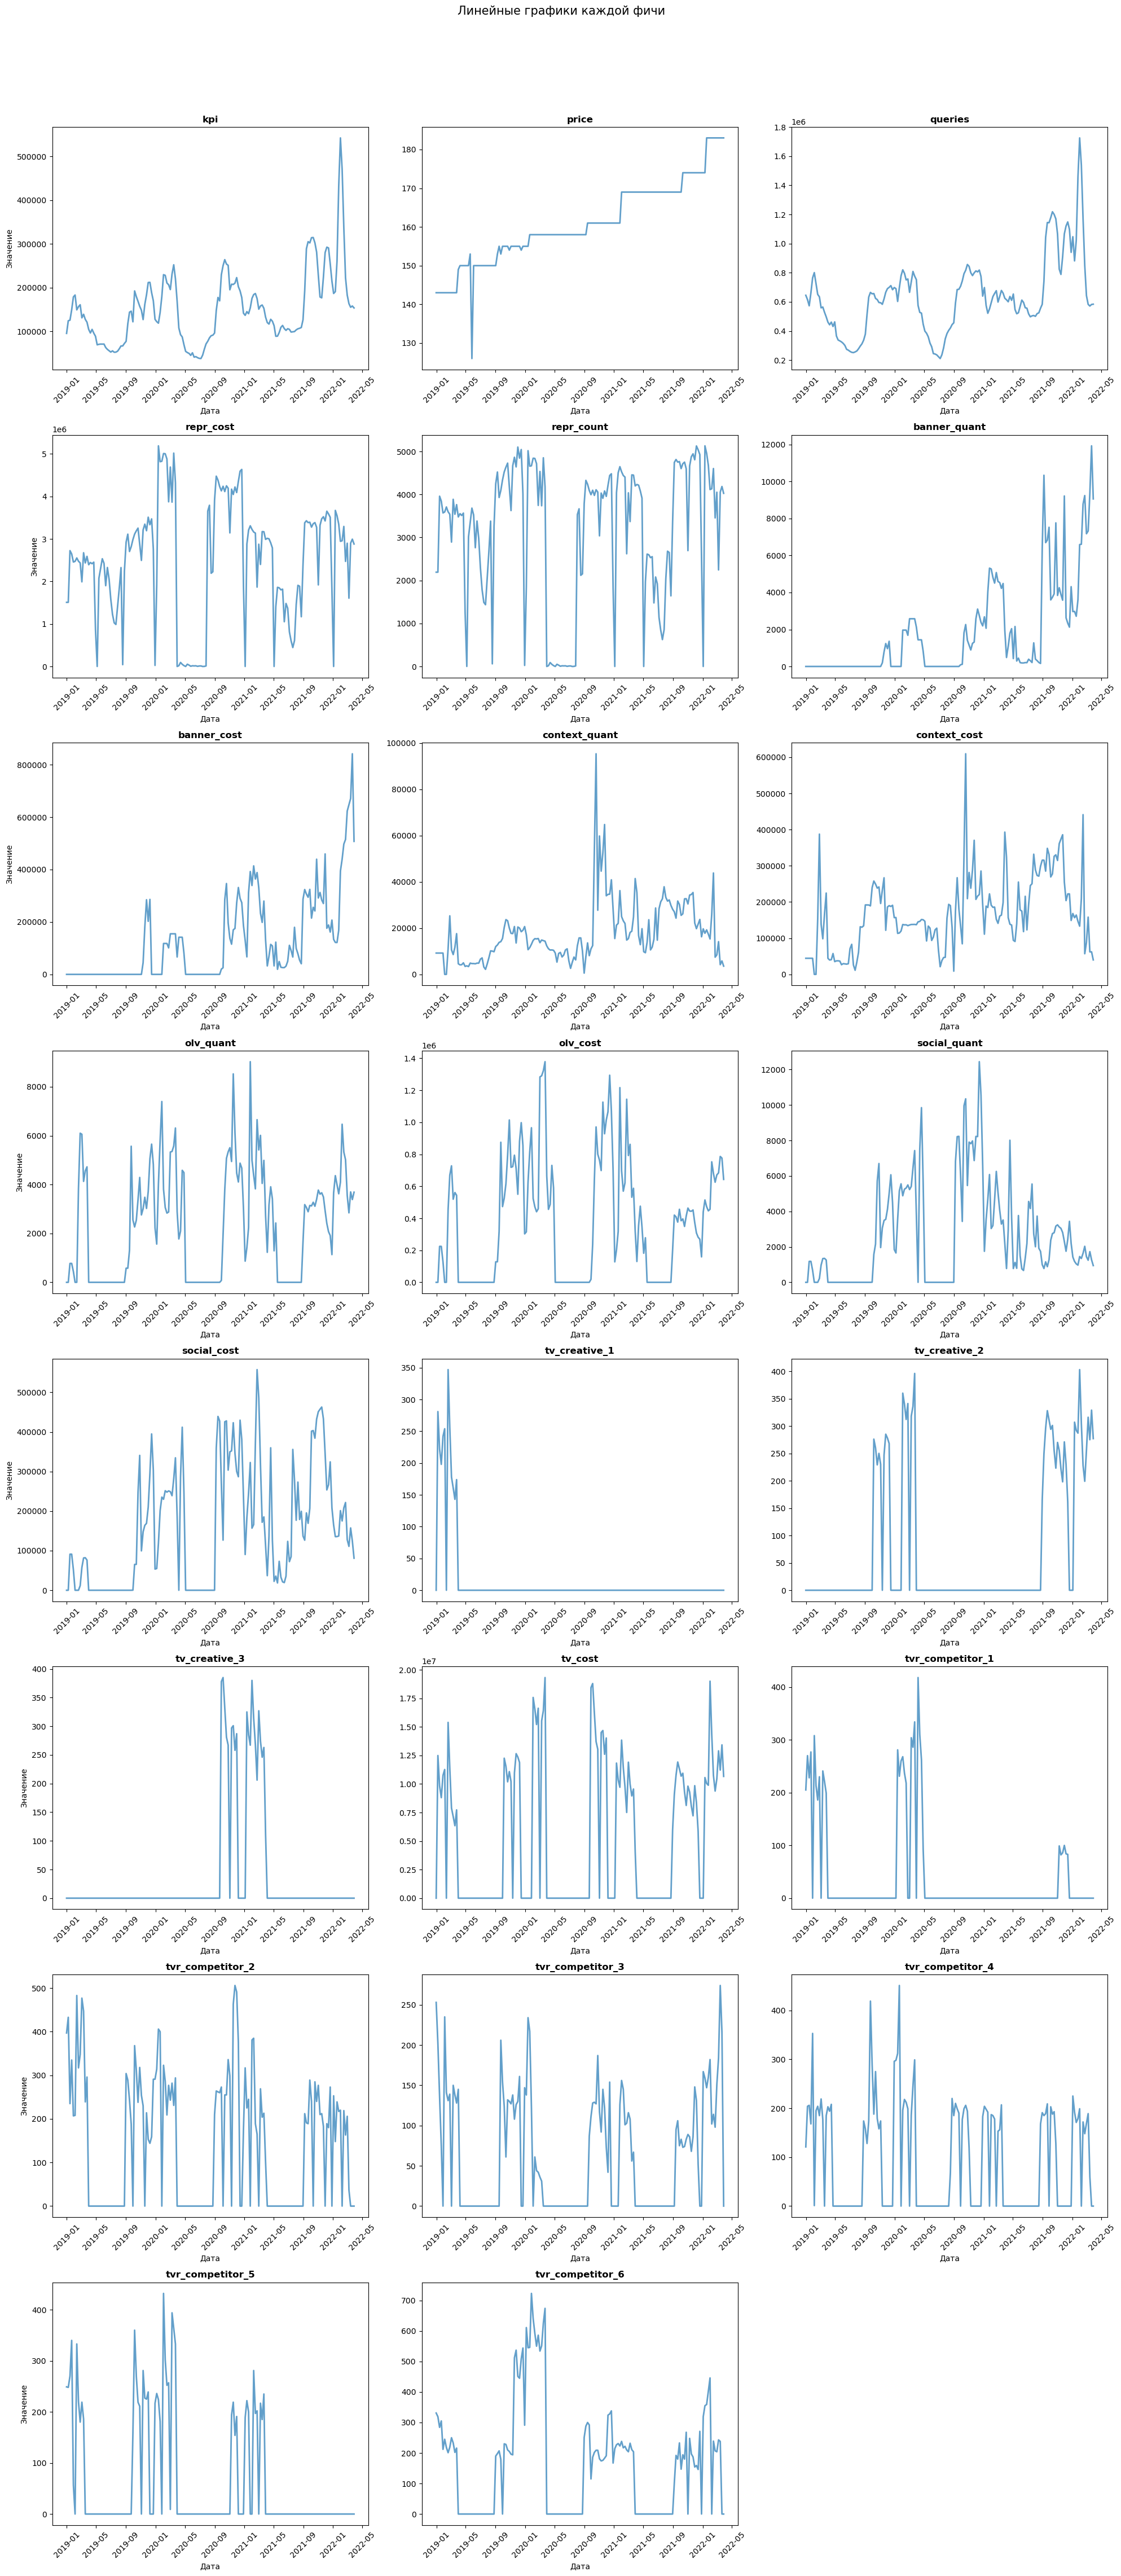

In [10]:
lineplot_for_numeric_df(data)

## Посмотрим на корреляцию признаков (больше всего интересует верхняя строка - то, как они коррелируют с kpi)

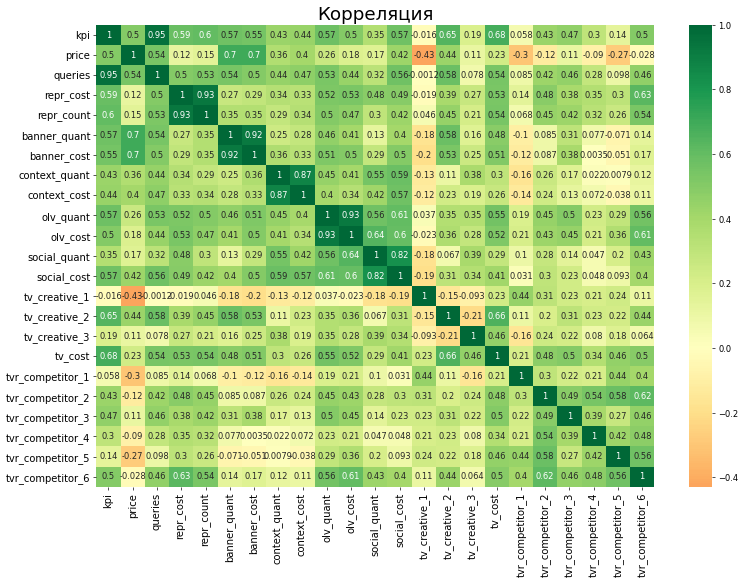

In [11]:
plt.figure(figsize=(15 , 10), dpi= 60)
sns.heatmap(data.corr(), xticklabels=data.corr().columns, yticklabels=data.corr().columns, cmap='RdYlGn', center=0, annot=True)
plt.title('Корреляция', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

## Для mmm полезно смотреть на данные от конкурентов, но в нашем случае я бы отказался от использования этих данных и сосредоточился бы на внутренних показателях для правильного распределения бюджета на медиа активности (по этой же причине выкину price и queries, а ещё потому что я их не понял:))

In [12]:
data.drop(columns = ['price' ,'queries' , 'tvr_competitor_1' , 'tvr_competitor_2' , 'tvr_competitor_3',  
                     'tvr_competitor_4' , 'tvr_competitor_5' , 'tvr_competitor_6'] , inplace = True)

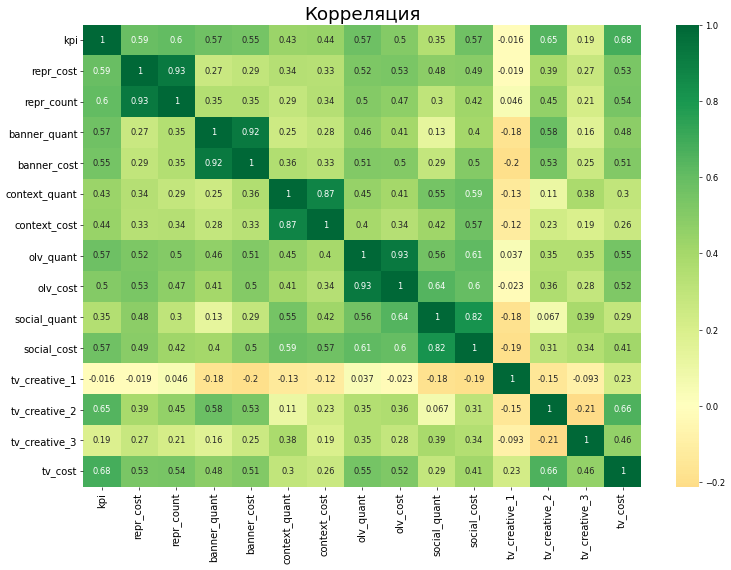

In [13]:
plt.figure(figsize=(15 , 10), dpi= 60)
sns.heatmap(data.corr(), xticklabels=data.corr().columns, yticklabels=data.corr().columns, cmap='RdYlGn', center=0, annot=True)
plt.title('Корреляция', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

## Поверхностно отобрал признаки, помимо таргета KPI осталось 14 других. Использую PCA (Метод главных компонент) для возможного уменьшения размерности набора данных

In [14]:
X = (data.drop(columns = 'kpi'))

In [15]:
scaler = StandardScaler() # standardscaler отнимает матожидание и делит на ско - получаем величину с м.о 0 и дисперсией 
data_scaled = scaler.fit_transform(X)

In [16]:
pca = PCA(n_components=None)
pca_result = pca.fit_transform(data_scaled)

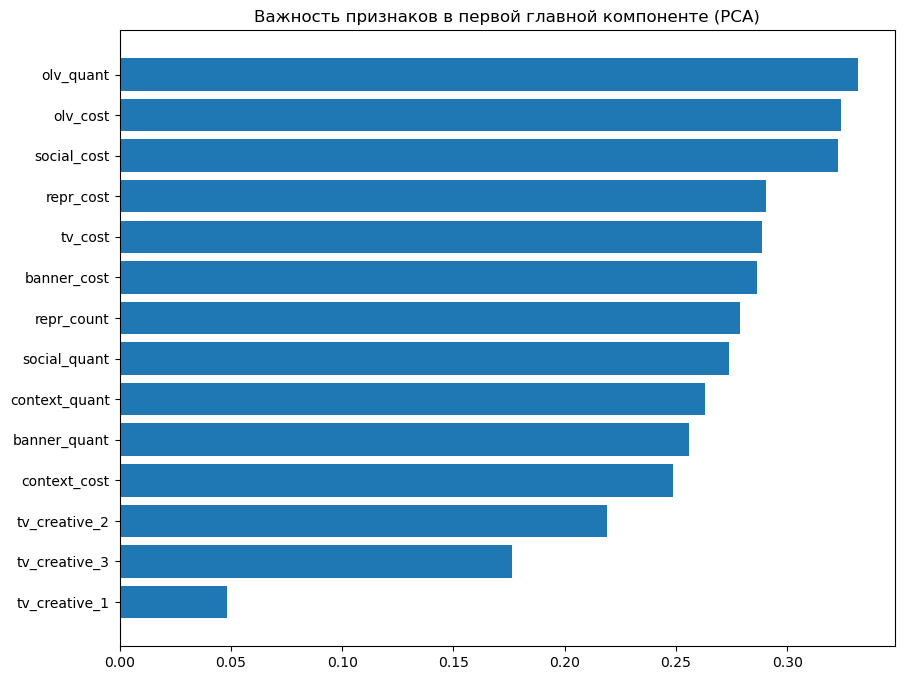

In [17]:
feature_importances = np.abs(pca.components_[0])
feature_names = X.columns
sorted_idx = np.argsort(feature_importances)[::-1]
plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), feature_names[sorted_idx])
plt.title('Важность признаков в первой главной компоненте (PCA)')
plt.gca().invert_yaxis()
plt.show()

## Создаю новые фичи: сложу все тв активности, поскольку имею данные только по общим затратам на тв, также рассчитаю стоимость одной единицы различных медиаактивностей

In [18]:
data['tv_creative'] = data['tv_creative_1'] + data['tv_creative_2'] + data['tv_creative_3']

In [19]:
data

,kpi,repr_cost,repr_count,banner_quant,banner_cost,context_quant,context_cost,olv_quant,olv_cost,social_quant,social_cost,tv_creative_1,tv_creative_2,tv_creative_3,tv_cost,tv_creative
date,,,,,,,,,,,,,,,,
2018-12-31,95353,1508543,2193,0,0,9221,44533,0,0,0,0,0,0,0,0,0
2019-01-07,124278,1508543,2193,0,0,9221,44533,0,0,0,0,281,0,0,12490514,281
2019-01-14,125637,2724790,3960,0,0,9221,44533,773,224607,1183,91153,222,0,0,9835858,222
2019-01-21,149294,2646358,3846,0,0,9221,44533,773,224607,1183,91153,198,0,0,8800458,198
2019-01-28,178678,2456814,3571,0,0,9221,44533,442,128347,676,52088,242,0,0,10754487,242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-28,182791,2898815,4053,7178,623279,8450,88478,3553,671514,1443,127644,0,256,0,10461422,256
2022-03-07,163479,1605684,2245,7326,647609,14166,158176,2843,683807,1247,110867,0,316,0,12902261,316
2022-03-14,155159,2901533,4056,9379,671192,4203,62097,3699,786629,1731,157480,0,275,0,11217103,275


In [20]:
data_for_model = pd.DataFrame()

In [21]:
data_for_model['kpi'] = data['kpi']

In [22]:
data_for_model['1unit_repr'] = (data['repr_cost'] /  data['repr_count']).fillna(0)

In [23]:
data_for_model['1unit_banner'] = (data['banner_cost'] /  data['banner_quant']).fillna(0)

In [24]:
data_for_model['1unit_context'] = (data['context_cost'] /  data['context_quant']).fillna(0)

In [25]:
data_for_model['1unit_olv'] = (data['olv_cost'] /  data['olv_quant']).fillna(0)

In [26]:
data_for_model['1unit_social'] = (data['social_cost'] /  data['social_quant']).fillna(0)

In [27]:
data_for_model['1unit_tv'] = (data['tv_cost'] /  data['tv_creative']).fillna(0)

In [28]:
data_for_model

,kpi,1unit_repr,1unit_banner,1unit_context,1unit_olv,1unit_social,1unit_tv
date,,,,,,,
2018-12-31,95353,687.890105,0.000000,4.829520,0.000000,0.000000,0.000000
2019-01-07,124278,687.890105,0.000000,4.829520,0.000000,0.000000,44450.227758
2019-01-14,125637,688.078283,0.000000,4.829520,290.565330,77.052409,44305.666667
2019-01-21,149294,688.080603,0.000000,4.829520,290.565330,77.052409,44446.757576
2019-01-28,178678,687.990479,0.000000,4.829520,290.377828,77.053254,44440.028926
...,...,...,...,...,...,...,...
2022-02-28,182791,715.226992,86.831847,10.470769,188.999156,88.457380,40864.929688
2022-03-07,163479,715.226726,88.398717,11.165890,240.523039,88.906977,40829.939873
2022-03-14,155159,715.368097,71.563280,14.774447,212.659908,90.976314,40789.465455


## Функция для теста Дики-Фуллера

In [29]:
def apply_adfuller_to_series(series):
    result = adfuller(series) 
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print("Num Of Lags : ", result[2])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')
        
    if result[1] < 0.05:
        print("Единичных корней нет, ряд стационарен.")
    else:
        print("Есть единичные корни, ряд не стационарен.")

## Не все ряды стационарны, нужно будет дифференцировать ряды в модели

In [30]:
for column in data_for_model.columns:
    print(f"Results for {column}:")
    apply_adfuller_to_series(data_for_model[column])
    print("\n")

Results for kpi:
ADF Statistic: -2.8132598199644376
p-value: 0.05640451800743398
Num Of Lags :  3
Critical Values:
	1%: -3.4703698981001665
	5%: -2.8791138497902193
	10%: -2.576139407751488
Есть единичные корни, ряд не стационарен.


Results for 1unit_repr:
ADF Statistic: -2.7546684642019215
p-value: 0.06504647780315671
Num Of Lags :  4
Critical Values:
	1%: -3.470616369591229
	5%: -2.8792214018977655
	10%: -2.57619681359045
Есть единичные корни, ряд не стационарен.


Results for 1unit_banner:
ADF Statistic: -3.798856390580043
p-value: 0.0029190373093586673
Num Of Lags :  0
Critical Values:
	1%: -3.469648263987657
	5%: -2.878798906308495
	10%: -2.5759713094779593
Единичных корней нет, ряд стационарен.


Results for 1unit_context:
ADF Statistic: -5.344510832250783
p-value: 4.42533516409498e-06
Num Of Lags :  1
Critical Values:
	1%: -3.4698858990744115
	5%: -2.8789026251889647
	10%: -2.5760266680839004
Единичных корней нет, ряд стационарен.


Results for 1unit_olv:
ADF Statistic: -3.9069

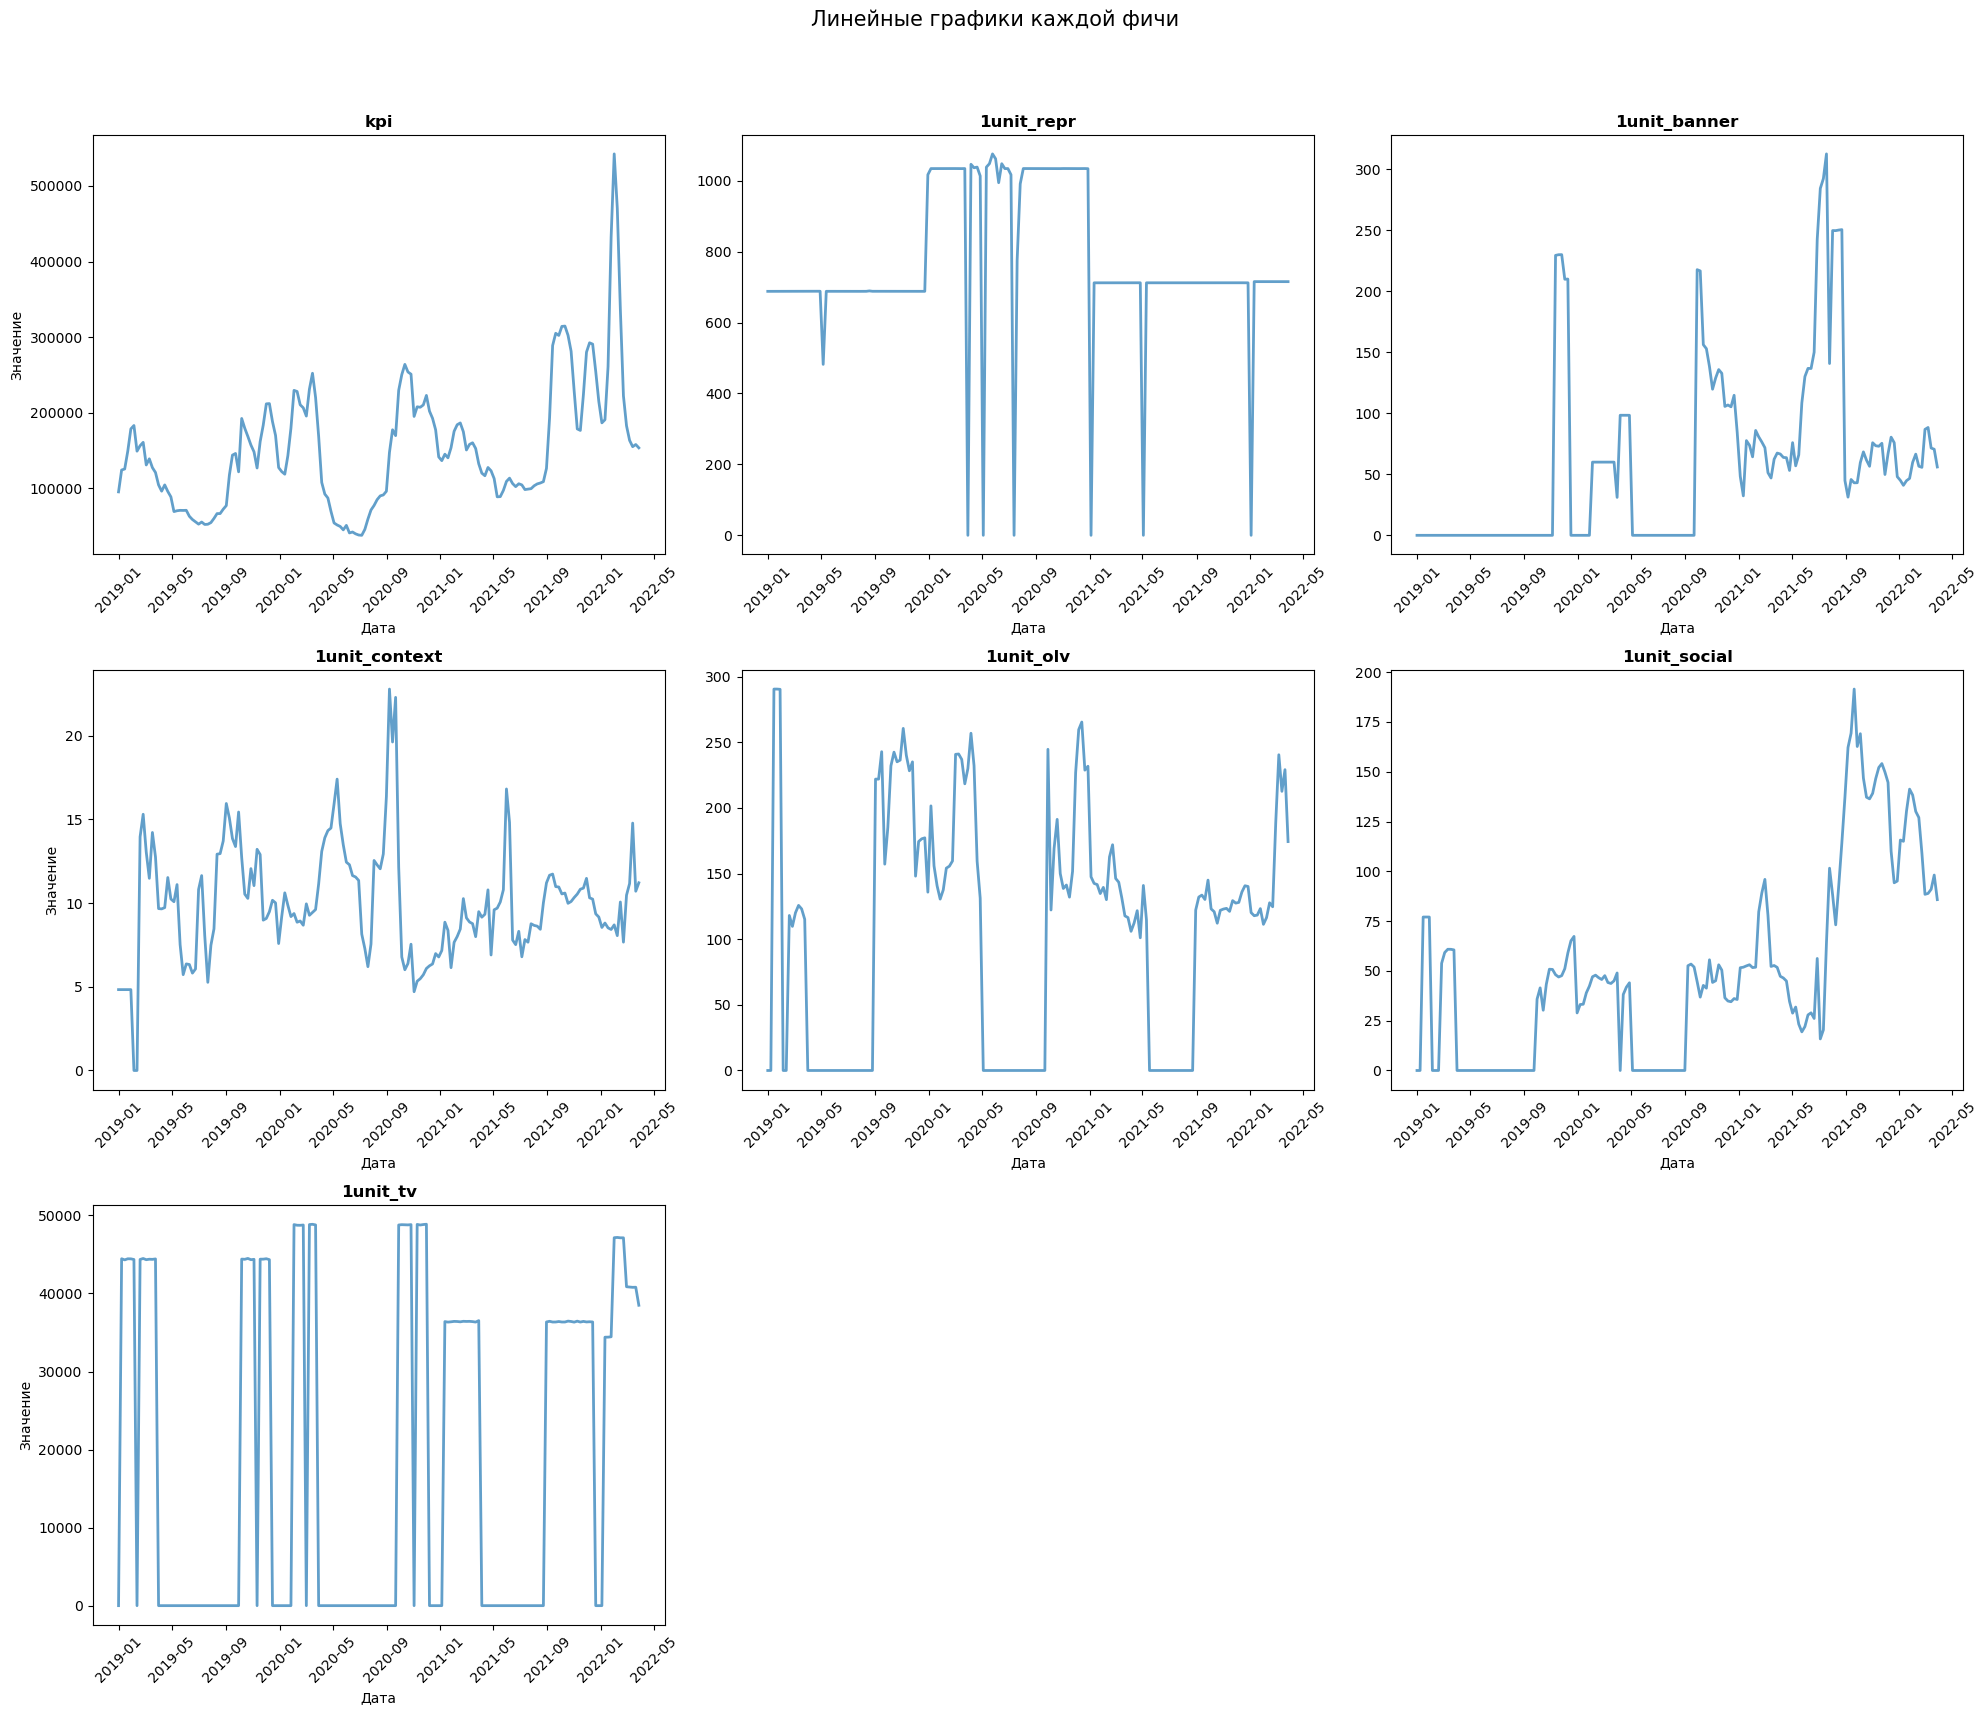

In [31]:
lineplot_for_numeric_df(data_for_model)

## Отрезаю куски для теста и трейна

In [32]:
X_train = data_for_model.drop(columns='kpi').iloc[:-30]
y_train = data_for_model['kpi'].iloc[:-30]               
X_test = data_for_model.drop(columns='kpi').iloc[-30:]
y_test = data_for_model['kpi'].iloc[-30:]

In [33]:
X_train

,1unit_repr,1unit_banner,1unit_context,1unit_olv,1unit_social,1unit_tv
date,,,,,,
2018-12-31,687.890105,0.000000,4.829520,0.000000,0.000000,0.000000
2019-01-07,687.890105,0.000000,4.829520,0.000000,0.000000,44450.227758
2019-01-14,688.078283,0.000000,4.829520,290.565330,77.052409,44305.666667
2019-01-21,688.080603,0.000000,4.829520,290.565330,77.052409,44446.757576
2019-01-28,687.990479,0.000000,4.829520,290.377828,77.053254,44440.028926
...,...,...,...,...,...,...
2021-08-02,712.000000,249.816121,8.664394,0.000000,88.154038,0.000000
2021-08-09,711.867214,249.761905,8.619760,0.000000,73.141060,0.000000
2021-08-16,711.919276,250.240741,8.431909,0.000000,92.995320,0.000000


## С помощью автоаримы подбираю параметры модели (p , d , q) (P , D , Q), указываю m=52(S) потому что сезонность имеет годовой характер, данные в TS недельные

In [34]:
model_sarimax = auto_arima(y_train, exog = X_train,  seasonal=True, m=52, stepwise=True, trace=True)
print(model_sarimax.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[52] intercept   : AIC=3149.320, Time=5.52 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=3466.723, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=3152.922, Time=0.85 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=3375.356, Time=0.62 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=3719.344, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[52] intercept   : AIC=3147.674, Time=1.54 sec
 ARIMA(2,0,2)(0,0,0)[52] intercept   : AIC=3155.764, Time=0.07 sec
 ARIMA(2,0,2)(0,0,2)[52] intercept   : AIC=3149.632, Time=5.17 sec
 ARIMA(2,0,2)(1,0,0)[52] intercept   : AIC=3147.381, Time=0.96 sec
 ARIMA(2,0,2)(2,0,0)[52] intercept   : AIC=3149.338, Time=6.59 sec
 ARIMA(2,0,2)(2,0,1)[52] intercept   : AIC=3151.318, Time=8.70 sec
 ARIMA(1,0,2)(1,0,0)[52] intercept   : AIC=3145.977, Time=0.76 sec
 ARIMA(1,0,2)(0,0,0)[52] intercept   : AIC=3155.405, Time=0.04 sec
 ARIMA(1,0,2)(2,0,0)[52] intercept   : AIC=3147.911, Time=5.36 sec
 ARIMA(1,0,2)(1,0,1

In [35]:
model_sarima = sm.tsa.SARIMAX(y_train, exog = X_train , order=(1, 0, 2), seasonal_order=(1, 0, 0, 52) , seasonal=True, m=52, stepwise=True, trace=True)
results_sarima = model_sarima.fit()

D:\for conda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
D:\for conda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
D:\for conda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## К сожалению, sarimax показала не лучшие результаты: только коэффициент при тв имеет статистическую значимость, все остальные  - нет. Тест Льюинга-Бокса говорит о том, что в остатках отсутствует автокорреляция, Тест Харке-Бера об отсутствии нормального распределения в них, а также стоит выделить наличие гетероскедастичности, всё это указывает на не самое лучшее качество модели, тем более, что предиктивная способность у нее тоже не самая лучшая, рассмотрю другие модели

In [36]:
results_sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                 kpi   No. Observations:                  140
Model:             SARIMAX(1, 0, 2)x(1, 0, [], 52)   Log Likelihood               -1581.949
Date:                             Thu, 04 Apr 2024   AIC                           3185.899
Time:                                     01:16:29   BIC                           3218.257
Sample:                                 12-31-2018   HQIC                          3199.048
                                      - 08-30-2021                                         
Covariance Type:                               opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
1unit_repr       -4.1791     15.715     -0.266      0.790     -34.979      26.621
1unit_banner     65.5784    109.792      0.597      0.550    -149.611     280.767
1unit_context   959.5890   1336.721      0.718      0.473   -1660.336    3579.514
1unit_olv       -27.4737     96.557     -0.285      0.776    -216.721     161.774
1unit_social    219.5336    276.836      0.793      0.428    -323.055     762.122
1unit_tv          0.6077      0.221      2.749      0.006       0.174       1.041
ar.L1             0.9942      0.012     79.921      0.000       0.970       1.019
ma.L1             0.2940      0.252      1.165      0.244      -0.201       0.789
ma.L2             0.1625      0.292      0.556      0.578      -0.410       0.735
ar.S.L52          0.0934      0.330      0.283      0.777      -0.553       0.740
sigma2         7.424e+08      0.001   1.38e+12      0.000    7.42e+08    7.42e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):                15.88
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):               0.47   Skew:                             0.44
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.87e+28. Standard errors may be unstable.
"""

## Делаю предикты с помощью SARIMAX

In [37]:
forecast_sarima = results_sarima.get_forecast(steps=30, exog=X_test)

In [38]:
y_predict = forecast_sarima.predicted_mean

In [39]:
y_predict

2021-09-06    135929.117692
2021-09-13    142439.302345
2021-09-20    145215.418458
2021-09-27    141323.613854
2021-10-04    145885.892777
2021-10-11    143032.441927
2021-10-18    139000.047598
2021-10-25    137251.717465
2021-11-01    137051.460473
2021-11-08    136720.427889
2021-11-15    137555.741276
2021-11-22    138084.305739
2021-11-29    137475.429877
2021-12-06    136932.979796
2021-12-13    128721.182867
2021-12-20     99895.089638
2021-12-27     94633.755546
2022-01-03    100337.378933
2022-01-10    116774.539120
2022-01-17    119056.639298
2022-01-24    122505.116792
2022-01-31    132691.092806
2022-02-07    130894.040987
2022-02-14    130571.718482
2022-02-21    122665.368900
2022-02-28    114637.965156
2022-03-07    114956.572572
2022-03-14    118930.667162
2022-03-21    115005.754460
2022-03-28    109573.626934
Freq: W-MON, Name: predicted_mean, dtype: float64

## Основные метрики для оценки качества предиктов модели

In [40]:
y_true = np.array(y_test)
y_pred = np.array(y_predict)
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [41]:
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R^2:", r2)
print("MAPE:", mape)

MAE: 135772.08643940758
MSE: 26224489239.632195
RMSE: 161939.770407495
R^2: -2.0649380402331423
MAPE: 47.03079401813783


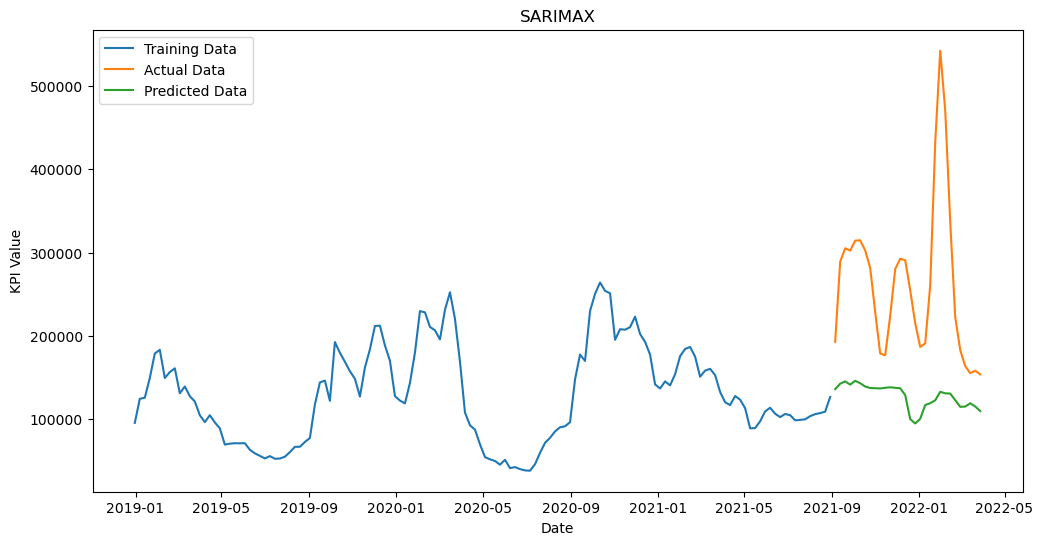

In [42]:
plt.figure(figsize=(12, 6))
plt.plot(y_train.index, y_train, label='Training Data')
plt.plot(y_test.index, y_test, label='Actual Data')
plt.plot(y_test.index, y_predict, label='Predicted Data')
plt.title('SARIMAX')
plt.xlabel('Date')
plt.ylabel('KPI Value')
plt.legend();

## Построю ACF для подбора лагов следующей модели

D:\for conda\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


<Figure size 1000x600 with 0 Axes>

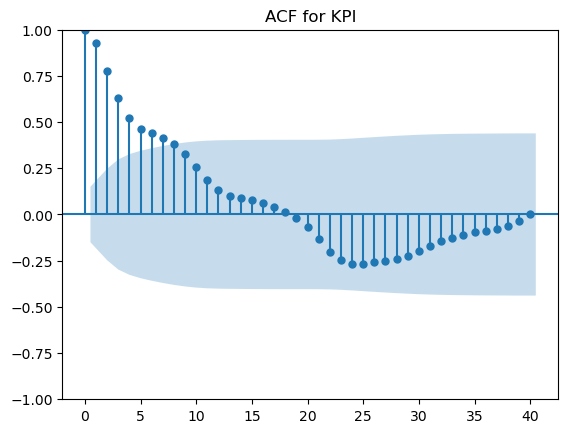

<Figure size 1000x600 with 0 Axes>

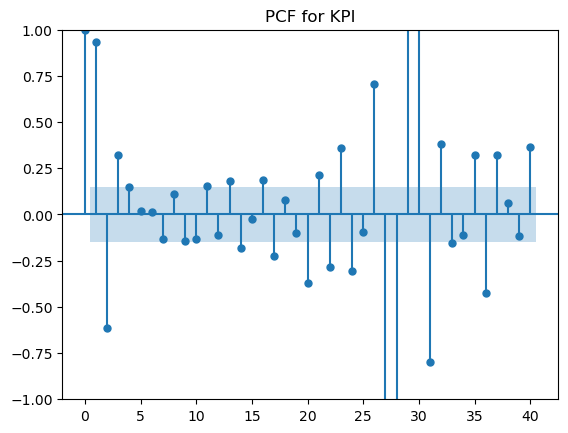

In [43]:
plt.figure(figsize=(10, 6))
plot_acf(data_for_model['kpi'], lags=40, alpha=0.05)
plt.title('ACF for KPI')
plt.plot();

plt.figure(figsize=(10, 6))
plot_pacf(data_for_model['kpi'], lags=40, alpha=0.05)
plt.title('PCF for KPI')
plt.plot();

## Попробую построить модель AR с теми же регрессорами

In [44]:
model_ar = AutoReg(endog=y_train, exog=X_train, lags=3)

D:\for conda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


## AR модель показывает результаты получше, коэффициенты при tv, online video, баннерах, прямом канале продаж - значимы, что очень и очень хорошо, контекстная реклама и продвижение в соц сетях - нет. Это можно связать с нестационарностью рядов, в целом, это не очень хорошая практика - использовать нестационарные ряды при работе, но kpi и расходы на прямые продажи имеют все равно довольно никзий p-value (~0.05), что со скрипом позволяет взять эти ряды без поправки не дифференциацию, а вот с расходами в соц сетях всё не так просто, но здесь я основываюсь на том, что модель SARIMAX подобрала d = 0, что косвенно говорит о том, что включение этого TS не так уж и критично, да и нужно будет учитывать, что при дифференцировании этого ряда, я буду работать с разностями значений, а не с самими значениями - нужно доработать в плане интерпртируемости результатов, что для нас важно! Поэтому - да, возможно, мы получили смещенные оценки, но очень много факторов указывают на то, что с этим можно жить

In [45]:
model_fitted_ar = model_ar.fit()
print(model_fitted_ar.summary())

                            AutoReg Model Results                             
Dep. Variable:                    kpi   No. Observations:                  140
Model:                   AutoReg-X(3)   Log Likelihood               -1510.446
Method:               Conditional MLE   S.D. of innovations          14856.806
Date:                Thu, 04 Apr 2024   AIC                           3042.892
Time:                        01:16:30   BIC                           3075.011
Sample:                    01-21-2019   HQIC                          3055.944
                         - 08-30-2021                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          7037.5701   6801.441      1.035      0.301   -6293.010    2.04e+04
kpi.L1            0.9844      0.077     12.747      0.000       0.833       1.136
kpi.L2           -0.1471      0.111     

In [46]:
residuals = model_fitted_ar.resid

## Небольшая положительная автокорреляция остатков скорее всего присутствует - мои границы зоны неопределенности ~ 1.7  и 1.8

<img src = '06labhjrn1276316386.png'/>

<img src = 'slide-61.jpg'/>

In [47]:
dw_stat = durbin_watson(residuals)
print(f"Статистика Дарбина-Уотсона: {dw_stat}")

Статистика Дарбина-Уотсона: 1.7096007295910494


## Остатки не имеют нормального распределения, о чем говорит гистограмма распределения остатков и тест Шапиро-Уилка

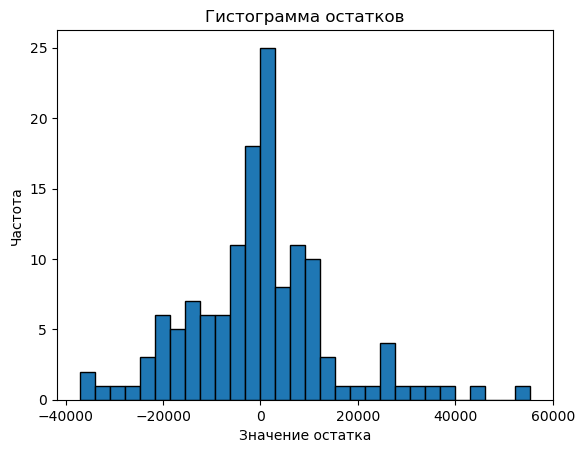

In [48]:
plt.hist(residuals, bins=30, edgecolor='k')
plt.title('Гистограмма остатков')
plt.xlabel('Значение остатка')
plt.ylabel('Частота')
plt.show()

In [49]:
shapiro_test = shapiro(residuals)
print(f"Тест Шапиро-Уилка: статистика={shapiro_test[0]}, p-значение={shapiro_test[1]}")

Тест Шапиро-Уилка: статистика=0.959193229675293, p-значение=0.00041908342973329127


## Очень хорошо, что ряд остатков стационарен, это указывает на "адекватность" модели и на учет всех систематических компонент данных 

In [50]:
apply_adfuller_to_series(residuals)

ADF Statistic: -10.002010409346935
p-value: 1.8734685044280133e-17
Num Of Lags :  0
Critical Values:
	1%: -3.4793722137854926
	5%: -2.8830370378332995
	10%: -2.578233635380623
Единичных корней нет, ряд стационарен.


## Попробую попрогнозировать на этой модели

In [51]:
start = len(y_train)
end = start + 29
y_predict = model_fitted_ar.predict(start=start, end=end , exog_oos = X_test)
print(y_predict)

2021-09-06    149074.355478
2021-09-13    169458.309363
2021-09-20    184265.677074
2021-09-27    192438.286621
2021-10-04    195232.424080
2021-10-11    194134.240748
2021-10-18    190192.492986
2021-10-25    186412.906727
2021-11-01    184458.213985
2021-11-08    184004.107653
2021-11-15    184512.406360
2021-11-22    186034.002943
2021-11-29    186366.823211
2021-12-06    186436.791857
2021-12-13    185680.764539
2021-12-20    165963.899442
2021-12-27    145414.112455
2022-01-03    118610.763944
2022-01-10    123624.670397
2022-01-17    135924.042394
2022-01-24    151604.916838
2022-01-31    170729.592352
2022-02-07    185572.979399
2022-02-14    196220.594006
2022-02-21    200003.007469
2022-02-28    202180.144838
2022-03-07    205511.855547
2022-03-14    207388.215866
2022-03-21    207887.596464
2022-03-28    202643.575969
Freq: W-MON, dtype: float64


D:\for conda\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


In [52]:
y_true = np.array(y_test)
y_pred = np.array(y_predict)
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## Однозначно прогнозы этой модели куда лучше SARIMAX

In [53]:
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R^2:", r2)
print("MAPE:", mape)

MAE: 99084.43447968928
MSE: 16450888224.515694
RMSE: 128261.01599673883
R^2: -0.9226667354398692
MAPE: 33.422909104099965


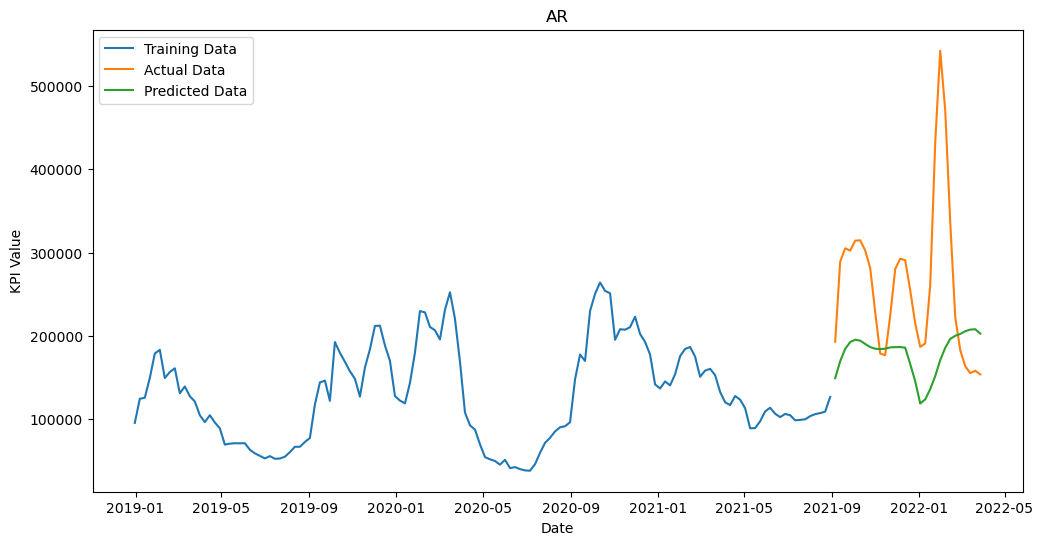

In [54]:
plt.figure(figsize=(12, 6))
plt.plot(y_train.index, y_train, label='Training Data')
plt.plot(y_test.index, y_test, label='Actual Data')
plt.plot(y_test.index, y_predict, label='Predicted Data')
plt.title('AR')
plt.xlabel('Date')
plt.ylabel('KPI Value')
plt.legend()
plt.show()

## Есть подозрение, что сезонность влияет куда сильнее чем любые другие переменные в модели, попробую посмотреть как с задачей прогнозирования справится Prophet

In [55]:
model = Prophet()

In [56]:
df = data_for_model.reset_index().rename(columns={'date': 'ds', 'kpi': 'y'})

In [57]:
train_df = df.iloc[:-30]
test_df = df.iloc[-30:]

In [58]:
df

,ds,y,1unit_repr,1unit_banner,1unit_context,1unit_olv,1unit_social,1unit_tv
0,2018-12-31,95353,687.890105,0.000000,4.829520,0.000000,0.000000,0.000000
1,2019-01-07,124278,687.890105,0.000000,4.829520,0.000000,0.000000,44450.227758
2,2019-01-14,125637,688.078283,0.000000,4.829520,290.565330,77.052409,44305.666667
3,2019-01-21,149294,688.080603,0.000000,4.829520,290.565330,77.052409,44446.757576
4,2019-01-28,178678,687.990479,0.000000,4.829520,290.377828,77.053254,44440.028926
...,...,...,...,...,...,...,...,...
165,2022-02-28,182791,715.226992,86.831847,10.470769,188.999156,88.457380,40864.929688
166,2022-03-07,163479,715.226726,88.398717,11.165890,240.523039,88.906977,40829.939873
167,2022-03-14,155159,715.368097,71.563280,14.774447,212.659908,90.976314,40789.465455
168,2022-03-21,158010,715.297898,70.552678,10.706337,229.165633,98.129921,40801.601824


## Парадоксально, но включение регрессоров ведет к падению предсказательной способности модели

In [59]:
#model.add_regressor('1unit_repr')
#model.add_regressor('1unit_banner')
#model.add_regressor('1unit_context')
#model.add_regressor('1unit_olv')
#model.add_regressor('1unit_social')
#model.add_regressor('1unit_tv')

In [60]:
model.fit(train_df)

01:16:32 - cmdstanpy - INFO - Chain [1] start processing
01:16:32 - cmdstanpy - INFO - Chain [1] done processing


In [61]:
forecast = model.predict(test_df)

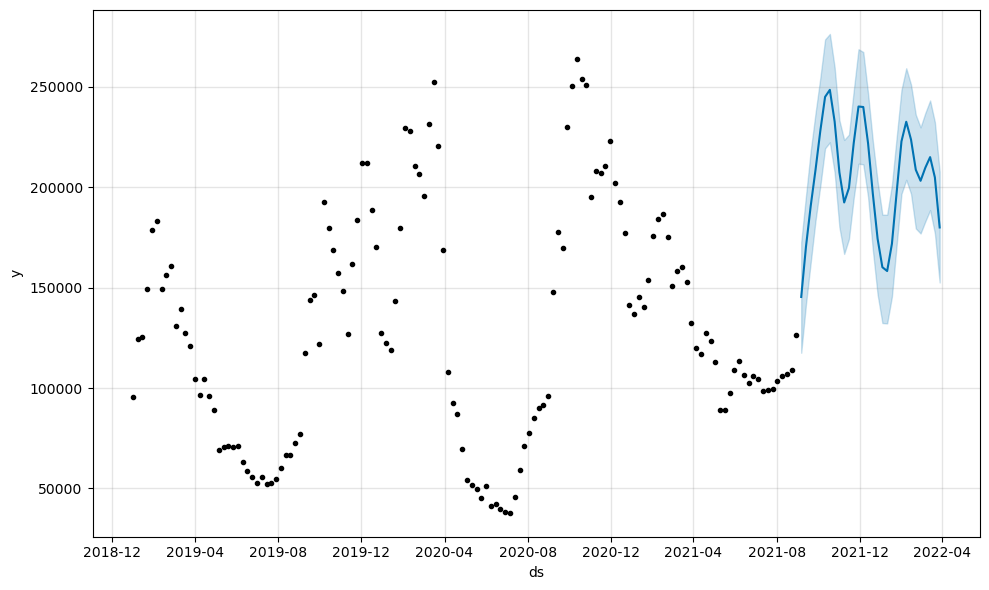

In [62]:
fig = model.plot(forecast)

In [63]:
y_predict = forecast['yhat']
y_predict

0     145321.122000
1     170423.421629
2     190808.633798
3     208651.943299
4     227969.144613
5     244927.567835
6     248417.033706
7     232625.179238
8     207360.078667
9     192356.623408
10    199593.033373
11    221953.448272
12    240125.038744
13    239874.023997
14    221881.888544
15    196723.885653
16    174321.627699
17    160134.694747
18    158217.960146
19    171774.050182
20    197588.550482
21    222778.662304
22    232532.662614
23    223664.327227
24    208621.943185
25    203144.216926
26    209671.068312
27    214932.207817
28    204814.219977
29    179917.737197
Name: yhat, dtype: float64

In [64]:
y_pred = np.array(y_predict)
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [65]:
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R^2:", r2)
print("MAPE:", mape)

MAE: 73999.70728092435
MSE: 10558374252.452768
RMSE: 102753.95005766333
R^2: -0.2339902063928443
MAPE: 24.704422314296885


## Даже без подбора параметров модель показывает очень хорошую предиктивную способность: сезонность и тренд очень важны для предсказания

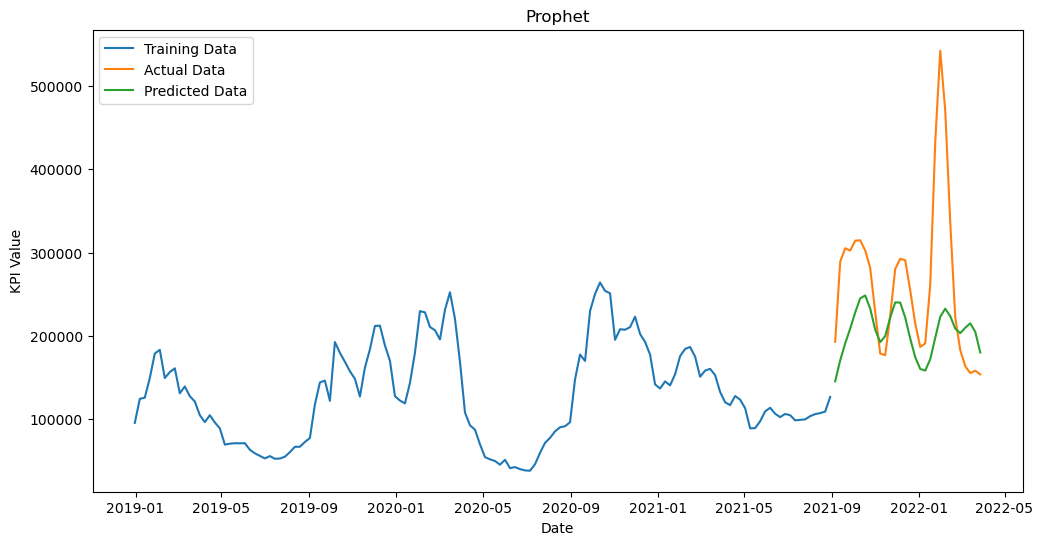

In [66]:
plt.figure(figsize=(12, 6))
plt.plot(y_train.index, y_train, label='Training Data')
plt.plot(y_test.index, y_test, label='Actual Data')
plt.plot(y_test.index, y_predict, label='Predicted Data')
plt.title('Prophet')
plt.xlabel('Date')
plt.ylabel('KPI Value')
plt.legend()
plt.show()

## Теперь нужно как-то поработать с оптимизацией микс-медиа: дать рекомендации по тому, сколько и куда нужно вкладывать. Это очень похоже решение задачи портфельной теории Марковица, где нужно найти веса для эффективного портфеля, если зацепиться за эту идею, то у нас есть оценки коэффициентов модели AR, каждый из коэффициентов говорит о том, как изменится kpi при 1% изменении регрессора при постоянстве других регрессоров, есть идея, что за счёт этого и озвученной идеи можно получить веса (распределение). Сделаю это следующим образом

In [67]:
w = {'Медиа': ['Прямой канал', 'Баннеры' , 'Контекстная реклама', 'Онлайн видео', 'Соц сети' , 'ТВ'], 
     'Значение': [12.6663, 41.9152, 427.4108, 53.7828 , 44.0637 , 0.4928]} 

In [68]:
w = pd.DataFrame(w)

In [69]:
w['Вес'] = w['Значение'] / w['Значение'].sum()

In [70]:
w_for_viz = w.sort_values(by = 'Вес' , ascending=False)

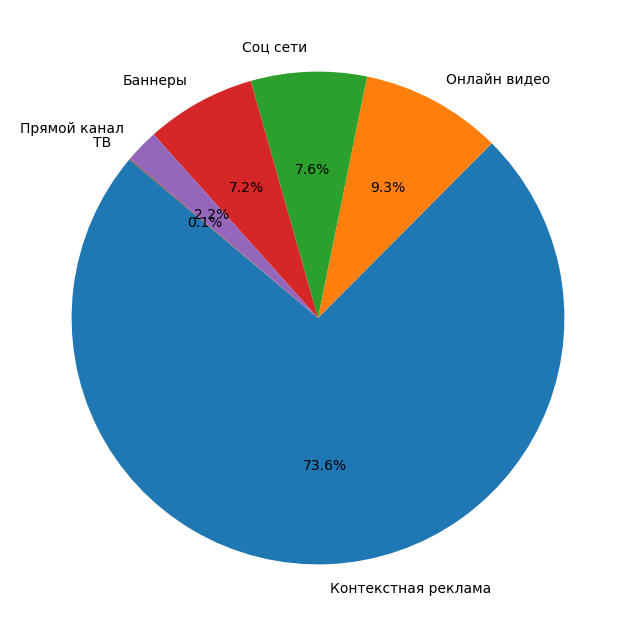

In [71]:
plt.figure(figsize=(10, 8)) 
plt.pie(w_for_viz['Вес'], labels=w_for_viz['Медиа'], autopct='%1.1f%%',startangle=140);